こんにちは、らんそうるいです。この記事では、バスケの世界でよく聞く定説「シュートを打てば打つほど、効率は下がっていく」（占有率と効率のトレードオフ trade-off between usage and efficiency）をB1_2020-21シーズンのデータを使って検討します。  
　なお、占有率と効率のトレードオフは[NBAstuffer](https://www.nbastuffer.com/analytics101/trade-off-between-usage-and-efficiency/)にとても簡単な説明があるので定説と紹介させていただきました。  
　USG％でGoogle検索すると、占有率と効率のトレードオフに言及している記事は散見されるのですが、よくよく見てみるとNBAではトレードオフが成立する（らしい）という内容が多かったです。では、Bリーグではどうなんだろう？　というのが、この記事を書いたモチベーションです。この話題は[筑紫次郎](https://twitter.com/Wo8i3EWTWUYiskO)様からいただきました。ありがとうございます。  
  
## 分析の方針
占有率と効率のトレードオフを検討するためには、占有率と効率を表す指標をそれぞれ用意し、それらが負の相関（片方が高いほど、片方が低くなるという関係）が見られるかどうか調べれば良いと考えました。そこで、占有率の指標としてUSG%を、効率を表す指標としてeFGとTS%を使用することにしました。  

### 定義式の確認
この節では、USG%、eFG、TS%の内容と定義式を確認します。ご存知の方は飛ばしていただいても大丈夫です。
　USG％、eFG、TS%についてそれぞれ説明します。USG%はチームのポゼッションの内、ある選手が終わらせたポゼッションの割合を表す指標です。次式で定義されます。$$USG rate=\frac{FGA+(0.44 \times FTA)+TO}{POSS_{team}}$$ただし、上式でFGAはフィールドゴール試投数、FTAはフリースロー試投数、TOはターンオーバー数です。そして、$POSS_{team}$は次式で計算します。$$POSS_{team}=FGA+(0.44 \times FTA)-OR+TO$$この式では、スタッツがそれぞれ個人ではなく、チームのものであることに注意してください。  
　eFGとTS%はどちらもシュートの効率を表す指標です。eFGは3Pシュートを加味したFG%で$$eFG=\frac{FGM+(0.5 \times F3GM)}{FGA}$$で定義されます。ここでFGMはフィールドゴール成功数、F3GMは３Pシュート成功数です。TS%は3Pに加えてフリースローでの得点も加味した指標で$$TS=\frac{PTS}{2 \times (FGA+0.44 \times FTA)}$$で定義されます。
 
## 分析
### データの準備
生データとしてrintaromasuda様の[github](https://github.com/rintaromasuda/bleaguer/tree/master/inst/extdata)から、teams.csvとgames_boxscore_202021.csv、games_summary_202021.csvを使用させていただきました。B1の選手のみを分析の対象にしました。データセットは2つ用意しました。一つはシーズン平均のUSG%、eFG、TS%を各選手について算出したデータセットです。もう一つは金丸晃輔選手の試合ごとのUSG%、eFG、TS%を算出したデータセットです。これらについてそれぞれスタッツ同士に負の相関関係が見られるかどうか検討しました。

### シーズン平均のスタッツを使ったトレードオフの検討

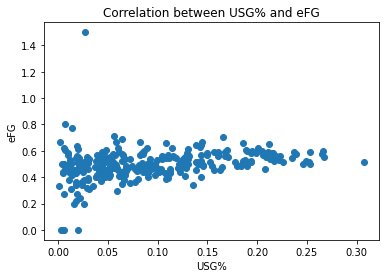

USG%とeFGの相関係数は、0.29537649312422437


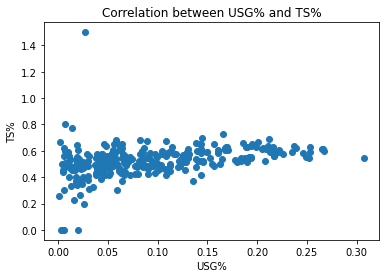

USG%とTS%の相関係数は、0.35589732870946145


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

#表示される列数・行数を増やしておく
pd.set_option("display.max_columns",100)
pd.set_option("display.max_rows",500)

#データの読み込み
boxscore=pd.read_csv("data/games_boxscore_202021.csv")
summary=pd.read_csv("data/games_summary_202021.csv")
teams=pd.read_csv("data/teams.csv")

#teamsからB1_202021シーズンのみを取り出す
teams=teams[teams["League"]=="B1"]
teams=teams[teams["Season"]=="2020-21"]
teams

#boxscoreとteamsをjoinして、B1_202021シーズンのデータセットを作る
boxscore=teams.merge(boxscore,on="TeamId")
boxscore

#summaryとteamsをjoinして、B1_202021シーズンのデータセットを作る
summary=teams.merge(summary,on="TeamId")
summary

#boxscoreで選手名でgroupbyして平均スタッツを算出する
boxscore=boxscore.groupby("Player").mean()
boxscore

#summaryでチーム名でgroupbyして平均スタッツを算出する
summary=summary.groupby("NameShort").mean()
summary

#インデックスをリセットする
boxscore=boxscore.reset_index()
summary=summary.reset_index()

#boxscoreに効率に関するスタッツを追加する
#まずeFG
eFG=[]
for fgm,f3gm,fga in zip(boxscore["FGM"],boxscore["F3GM"],boxscore["FGA"]):
    if fga==0:
        eFG.append(np.nan)
    else:
        eFG.append((fgm+0.5*f3gm)/fga)

boxscore["eFG"]=eFG

#boxscoreに効率に関するスタッツを追加する
#次にTS%
TS=[]
for pts,fga,fta in zip(boxscore["PTS"],boxscore["FGA"],boxscore["FTA"]):
    if 2*(fga+(0.44*fta))==0:
        TS.append(np.nan)
    else:
        TS.append(pts/(2*(fga+(0.44*fta))))

boxscore["TS%"]=TS

#USG%の分子を計算してboxscoreに追加する
usg=[]
for fga,fta,to in zip(boxscore["FGA"],boxscore["FTA"],boxscore["TO"]):
    usg.append(fga+(0.44*fta)+to)
    
boxscore["usg"]=usg

#boxscoreから必要な列だけ抽出する
boxscore=boxscore.loc[:,["Player","MIN","TeamId","eFG","TS%","usg"]]

#summaryからPOSSを計算する
poss=[]
for f2ga,f3ga,fta,orb,to in zip(summary["F2GA"],summary["F3GA"],summary["FTA"],summary["OR"],summary["TO"]):
    fga=f2ga+f3ga
    poss.append(fga+fta*0.44-orb+to)
summary["POSS"]=poss

#summaryから必要な列だけを抽出する
summary=summary.loc[:,["NameShort","TeamId","POSS"]]

#boxscoreのTeamIdでなぜか小数点以下が出現するので切り捨てる
ID=[]

for teamid in boxscore["TeamId"]:
    teamid=math.floor(teamid)
    ID.append(teamid)
    
boxscore["TeamId"]=ID

#boxscoreとsummaryをTeamIdでjoinする
data=summary.merge(boxscore,on="TeamId")
data

#USG%を計算してdataに追加する
USG=[]
for poss, usg in zip(data["POSS"],data["usg"]):
    USG.append(usg/poss)
    
data["USG%"]=USG

#USG%とeFGの相関を調べる
plt.plot(data["USG%"],data["eFG"],"o")
plt.title("Correlation between USG% and eFG")
plt.ylabel("eFG")
plt.xlabel("USG%")
plt.show()

print("USG%とeFGの相関係数は、"+str(data["USG%"].corr(data["eFG"])))

#USG%とTS%の相関を調べる
plt.plot(data["USG%"],data["TS%"],"o")
plt.title("Correlation between USG% and TS%")
plt.ylabel("TS%")
plt.xlabel("USG%")
plt.show()

print("USG%とTS%の相関係数は、"+str(data["USG%"].corr(data["TS%"])))

### 金丸選手の試合ごとのスタッツを使ったトレードオフの検討

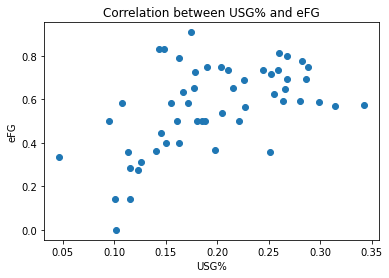

USG%とeFGの相関係数は、0.5298238962451095


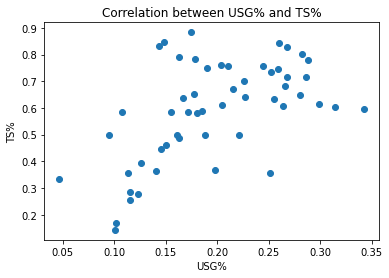

USG%とTS%の相関係数は、0.5559426574271056


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

#表示される列数・行数を増やしておく
pd.set_option("display.max_columns",100)
pd.set_option("display.max_rows",500)

#データの読み込み
boxscore=pd.read_csv("data/games_boxscore_202021.csv")
summary=pd.read_csv("data/games_summary_202021.csv")
teams=pd.read_csv("data/teams.csv")

#boxscoreから金丸晃輔選手のデータを抽出する
kanamaru=boxscore[boxscore["Player"]=="金丸晃輔"]

#teamsからB1_2020-21シーズンの三河のデータだけ取り出す
teams=teams[teams["Season"]=="2020-21"]
teams=teams[teams["NameShort"]=="三河"]
teams

#summaryとteamsをjoinして、summaryから三河のデータだけ取り出す
summary=teams.merge(summary,on="TeamId")

#indexをリセットする
kanamaru=kanamaru.reset_index()
summary=summary.reset_index()

#kanamaruから効率の指標を計算する
#eFGから
eFG=[]
for fgm,f3gm,fga in zip(kanamaru["FGM"],kanamaru["F3GM"],kanamaru["FGA"]):
    if fga==0:
        eFG.append(np.nan)
    else:
        eFG.append((fgm+0.5*f3gm)/fga)

kanamaru["eFG"]=eFG

#TS%を計算する
TS=[]
for pts,fga,fta in zip(kanamaru["PTS"],kanamaru["FGA"],kanamaru["FTA"]):
    if 2*(fga+(0.44*fta))==0:
        TS.append(np.nan)
    else:
        TS.append(pts/(2*(fga+(0.44*fta))))

kanamaru["TS%"]=TS

#USG%の分子を計算してboxscoreに追加する
usg=[]
for fga,fta,to in zip(kanamaru["FGA"],kanamaru["FTA"],kanamaru["TO"]):
    usg.append(fga+(0.44*fta)+to)
    
kanamaru["usg"]=usg

#boxscoreから必要な列だけ抽出する
kanamaru=kanamaru.loc[:,["Player","MIN","ScheduleKey","eFG","TS%","usg"]]

#summaryからPOSSを計算する
poss=[]
for f2ga,f3ga,fta,orb,to in zip(summary["F2GA"],summary["F3GA"],summary["FTA"],summary["OR"],summary["TO"]):
    fga=f2ga+f3ga
    poss.append(fga+fta*0.44-orb+to)
summary["POSS"]=poss

#summaryから必要な列だけを抽出する
summary=summary.loc[:,["NameShort","ScheduleKey","POSS"]]

#boxscoreとsummaryをTeamIdでjoinする
data=summary.merge(kanamaru,on="ScheduleKey")
data

#USG%を計算してdataに追加する
USG=[]
for poss, usg in zip(data["POSS"],data["usg"]):
    USG.append(usg/poss)
    
data["USG%"]=USG

#USG%とeFGの相関を調べる
plt.plot(data["USG%"],data["eFG"],"o")
plt.title("Correlation between USG% and eFG")
plt.ylabel("eFG")
plt.xlabel("USG%")
plt.show()

print("USG%とeFGの相関係数は、"+str(data["USG%"].corr(data["eFG"])))

#USG%とTS%の相関を調べる
plt.plot(data["USG%"],data["TS%"],"o")
plt.title("Correlation between USG% and TS%")
plt.ylabel("TS%")
plt.xlabel("USG%")
plt.show()

print("USG%とTS%の相関係数は、"+str(data["USG%"].corr(data["TS%"])))

## 結果
シーズン平均のスタッツを使ったトレードオフの検討では、USG%とeFG、USG%とTS%に弱いながら正の相関（片方が高いほど、もう片方も高いという関係）が見られました。つまり、占有率と効率のトレードオフは確認できませんでした。  
　金丸選手の試合ごとのスタッツを使ったトレードオフの検討でも、同様にUSG%とeFG、USG%とTS%に正の相関が見られました。つまり、占有率と効率のトレードオフは確認できませんでした。 
 
## 終わりに
この記事では、バスケの世界でよく聞く定説「シュートを打てば打つほど、効率は下がっていく」をB1_2020-21シーズンのデータを使って検討しました。その結果、シーズン平均の各選手の占有率と効率のデータを使った場合でも、金丸選手の試合ごとの占有率と効率のデータを使った場合でも、占有率と効率に負の相関（片方が高いほど、もう片方は低い関係）は確認できませんでした。  
　ただ、選手内での検討は金丸選手のデータしか行っていないので、他の選手では占有率と効率のトレードオフが確認できる可能性は否定できません。コードをほんの少し変更するだけで、他の選手のデータを使った検討はできるので、ご興味のある方はぜひ検討してみてください。  
 　最後に、分析のアイディアをくださった[筑紫次郎](https://twitter.com/Wo8i3EWTWUYiskO)様、選手内で検討することを提案してくださった[B League Impact Metrices](https://twitter.com/B_ImpactMetrics)様に感謝いたします。ありがとうございました。